In [ ]:
!pip install scikit-learn -q

Upload your MAGIC dataset file: magic04.data


Saving magic04.data to magic04.data
Using file: magic04.data
First 5 rows:


,fLength,fWidth,fSize,fConc,fConc1,fAsym,fM3Long,fM3Trans,fAlpha,fDist,class
0,28.7967,16.0021,2.6449,0.3918,0.1982,27.7004,22.0110,-8.2027,40.0920,81.8828,g
1,31.6036,11.7235,2.5185,0.5303,0.3773,26.2722,23.8238,-9.9574,6.3609,205.2610,g
2,162.0520,136.0310,4.0612,0.0374,0.0187,116.7410,-64.8580,-45.2160,76.9600,256.7880,g
3,23.8172,9.5728,2.3385,0.6147,0.3922,27.2107,-6.4633,-7.1513,10.4490,116.7370,g
4,75.1362,30.9205,3.1611,0.3168,0.1832,-5.5277,28.5525,21.8393,4.6480,356.4620,g


Shape: (19020, 11)
Class counts (g=gamma, h=hadron):
class
g    12332
h     6688
Name: count, dtype: int64
Train shape: (13314, 10)
Test shape: (5706, 10)

=== TEST PERFORMANCE ===
Accuracy: 0.8792
ROC-AUC: 0.9350

Confusion Matrix:
[[1522  484]
 [ 205 3495]]

Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.76      0.82      2006
           1       0.88      0.94      0.91      3700

    accuracy                           0.88      5706
   macro avg       0.88      0.85      0.86      5706
weighted avg       0.88      0.88      0.88      5706



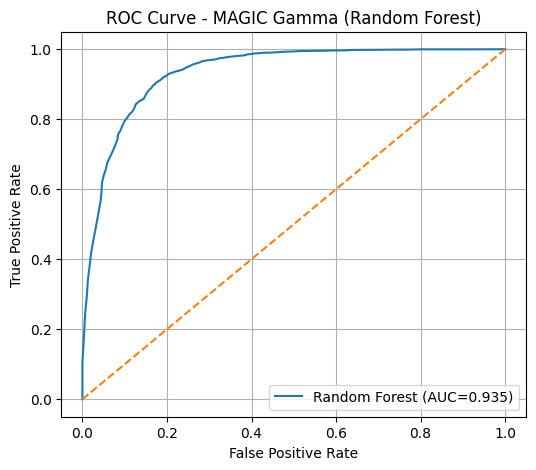

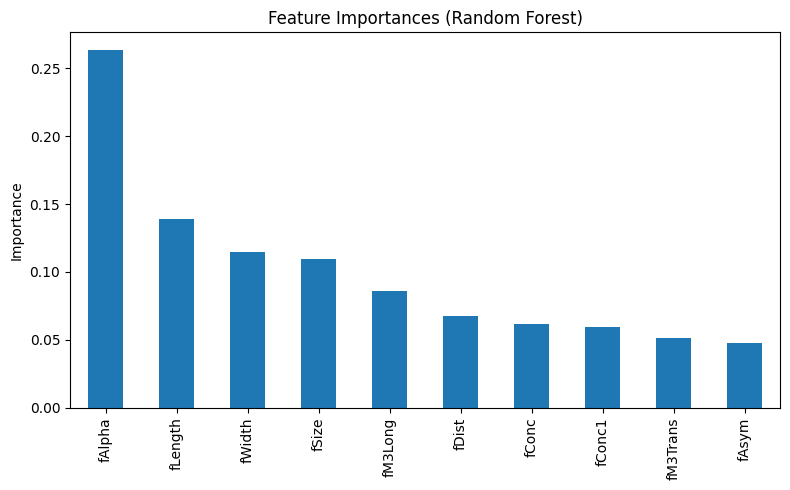

In [ ]:
# =====================================================
# SIMPLE MAGIC GAMMA PROJECT - USING magic04.data
# =====================================================

# 1. Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    roc_auc_score,
    roc_curve
)

from google.colab import files
%matplotlib inline

# 2. Upload the MAGIC dataset (magic04.data)
print("Upload your MAGIC dataset file: magic04.data")
uploaded = files.upload()

# Use the uploaded file name
file_name = list(uploaded.keys())[0]
print("Using file:", file_name)

# Column names taken from magic04.names (UCI description)
col_names = [
    "fLength", "fWidth", "fSize", "fConc", "fConc1",
    "fAsym", "fM3Long", "fM3Trans", "fAlpha", "fDist", "class"
]

# 3. Read the .data file (it's comma-separated, no header)
df = pd.read_csv(file_name, header=None, names=col_names)

print("First 5 rows:")
display(df.head())
print("Shape:", df.shape)
print("Class counts (g=gamma, h=hadron):")
print(df["class"].value_counts())

# 4. Preprocessing
# Convert target: g -> 1 (gamma signal), h -> 0 (hadron background)
df["class"] = df["class"].map({"g": 1, "h": 0})

X = df.drop("class", axis=1)
y = df["class"]

# 5. Train-test split (70% train, 30% test, stratified)
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.3,
    random_state=42,
    stratify=y
)

print("Train shape:", X_train.shape)
print("Test shape:", X_test.shape)

# 6. Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 7. Train a simple Random Forest model
rf = RandomForestClassifier(
    n_estimators=100,
    random_state=42,
    class_weight="balanced"   # helps if classes are a bit imbalanced
)

rf.fit(X_train_scaled, y_train)

# 8. Evaluation on test set
y_pred = rf.predict(X_test_scaled)
y_proba = rf.predict_proba(X_test_scaled)[:, 1]

acc = accuracy_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_proba)

print("\n=== TEST PERFORMANCE ===")
print(f"Accuracy: {acc:.4f}")
print(f"ROC-AUC: {auc:.4f}")

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# 9. ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_proba)

plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f"Random Forest (AUC={auc:.3f})")
plt.plot([0, 1], [0, 1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - MAGIC Gamma (Random Forest)")
plt.legend()
plt.grid(True)
plt.show()

# 10. Feature importance plot
importances = rf.feature_importances_
feat_imp = pd.Series(importances, index=X.columns).sort_values(ascending=False)

plt.figure(figsize=(8, 5))
feat_imp.plot(kind="bar")
plt.title("Feature Importances (Random Forest)")
plt.ylabel("Importance")
plt.tight_layout()
plt.show()
